# Intent Classifier Model

**Set Up Transformer & Import Required Libraries**

We are using **BERT** model

Took help from the following [Github page](https://hannibunny.github.io/mlbook/transformer/intent_classification_with_bert.html)

In [ ]:
!pip install -q tensorflow-text

In [ ]:
#!pip install -U "tensorflow==2.11.*"
!pip install -q -U "tensorflow-text==2.11.*"
import tensorflow as tf
import tensorflow_text as text
import functools
print("TensorFlow version: ", tf.__version__)

TensorFlow version:  2.11.1


In [ ]:

import os
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

import warnings
warnings.filterwarnings("ignore")

In [ ]:
import numpy as np
import pandas as pd
import json
import os
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Embedding, Activation, LSTM, SimpleRNN, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import bert
from tqdm import tqdm
from tensorflow.keras import backend as K
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
tf.get_logger().setLevel('ERROR')

import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install bert-for-tf2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.9-py3-none-any.whl size=30531 sha256=d48ec839f856b837ffe295d518c3068ffbd00b8cdafbdec76e93ba7743bb8395
  Stored in directory: /root/.cache/pip/wheels/d8/da/50/126d7b8416d9a0e6bf876935c2219a71e72a6529c25e150c56
  Created wheel for params-flow: filename=params_flow-0.8.2-py3-none-any.whl size=19471 sha256=3a05cf8c1fc96cd04040ea4049ad0cb04fb3f8c9b30849094d000cc07634cd73
  Stored in directory: /root/.cache/pip/wheels/97/a8/d0/f7419404174976a2686bb98b5c30df01cc71445415f32db9e6
  Created wheel for py-params: filename=py_params-0.10.2-py3-none-any.whl size=7910 sha256=9df1fc03aa3d1a897dfb21cfab9a98ee17849011447e43b8bf085de2fca4267f
  Sto

In [ ]:
# Loading our intent classifier data that we saved in last notebook
traindf = pd.read_csv('train.csv')
validdf = pd.read_csv('valid.csv')
testdf = pd.read_csv('test.csv')

In [ ]:
# Dropping missing values
traindf.dropna(inplace=True)
validdf.dropna(inplace=True)
testdf.dropna(inplace=True)

**Binarizing/one-hot encoding** class-labels of train, test and validation data to be effectively fed into the model.

In [ ]:
from sklearn.preprocessing import LabelBinarizer
binarizer=LabelBinarizer()
trainlabels=binarizer.fit_transform(traindf['intent'])
testlabels=binarizer.transform(testdf['intent'])
validlabels=binarizer.transform(validdf['intent'])

**Loading models from Tensorflow Hub**

According to the text there are multiple BERT models available some of them are listed below.

We will use **small BERT uncased** model with trained weights released by the original BERT authors.

Small BERT models are faster to fine-tune as they have fewer parameters. Based on accuracy we might tweak different models and see which one is good for our data.

In [ ]:
bert_model_name = 'small_bert/bert_en_uncased_L-8_H-512_A-8'
map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/2',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/2',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/2',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2


Text input to be tokenized and converted to tensors before feeding into BERT.

TFops from the **TF.text** library does that job.

The preprocessing model must be the one referenced by the documentation of the **BERT model**, which we got as **BERT model selected** in above output.

We will load the preprocessing model into a **hub.KerasLayer** to compose our fine-tuning model

In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

**BERT Model**

In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
# Define the model with one dense and one dropout layer

def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.15)(net)
  net = tf.keras.layers.Dense(6, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
classifier_model = build_classifier_model()

**Model Architecture**


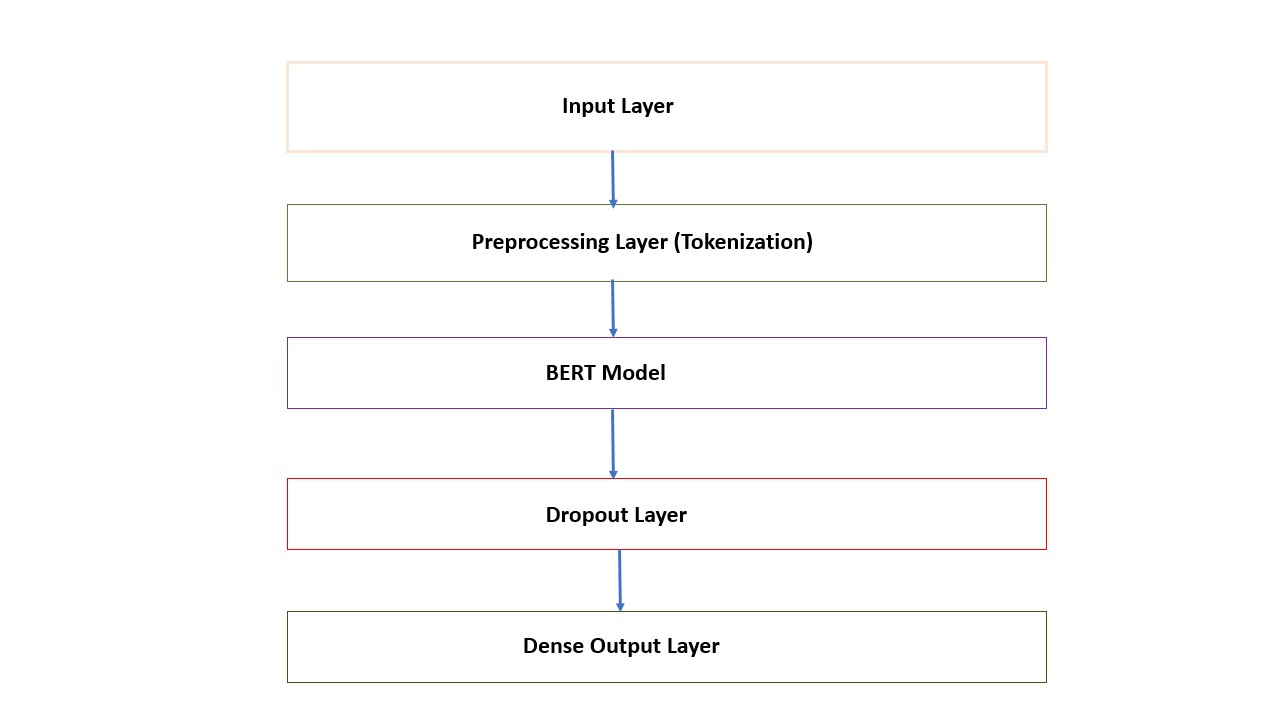

In [ ]:
# Model structure

classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

After model is finalized, we finalize our **hyperparameters** like optimizers, epochs and **loss function**.

In [ ]:
# we use CategoricalCrossentropy

loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metrics = tf.metrics.CategoricalAccuracy()

In [ ]:
epochs=2
optimizer=tf.keras.optimizers.Adam(1e-4)
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
#(trainfeatures.shape,trainlabels.shape,validfeatures.shape,validlabels.shape)

In [ ]:
# Training
#print(f'Training model with {tfhub_handle_encoder}')
#history = classifier_model.fit(x=trainfeatures,y=trainlabels,
history = classifier_model.fit(x=traindf['text'].values,y=trainlabels,
                               validation_data=(validdf['text'].values,validlabels),
                               batch_size=32,
                               epochs=epochs)

Epoch 1/2
187/187 [==============================] - 3732s 20s/step - loss: 0.4352 - categorical_accuracy: 0.8098 - val_loss: 0.3150 - val_categorical_accuracy: 0.8308
Epoch 2/2
187/187 [==============================] - 3510s 19s/step - loss: 0.3318 - categorical_accuracy: 0.8446 - val_loss: 0.3415 - val_categorical_accuracy: 0.8451


In [ ]:
# save the model for later use
classifier_model.save('my_model')

In [ ]:
loss, accuracy = classifier_model.evaluate(testdf['text'],testlabels)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

23/23 [==============================] - 122s 5s/step - loss: 0.3354 - categorical_accuracy: 0.8587
Loss: 0.3354099690914154
Accuracy: 0.8586956262588501


Accuracy on test dataset is **86%** which is not bad. We can try to improve more by running it through more number of epochs or by proper hyperparameter tuning.

Now lets give some proper random sentences and see if it could perform the intent classifcation well.

In [ ]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : estimated intent: {results[i]}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'What is current weather now?',
    'Please open front door',
    'Why it is rainy now?']

results = tf.nn.softmax(classifier_model(tf.constant(examples)))

In [ ]:
results

<tf.Tensor: shape=(3, 6), dtype=float32, numpy=
array([[9.75371586e-05, 3.73507006e-04, 6.68583089e-04, 3.94110772e-04,
        8.04918382e-05, 9.98385787e-01],
       [2.07661782e-04, 9.98716354e-01, 3.03182343e-04, 3.47727764e-05,
        7.18776137e-04, 1.93081523e-05],
       [1.18877986e-04, 5.59184467e-04, 1.41071505e-03, 2.69569969e-03,
        6.59291109e-05, 9.95149672e-01]], dtype=float32)>

In [ ]:
intents=binarizer.inverse_transform(results.numpy())

In [ ]:
print_my_examples(examples, intents)

input: What is current weather now?   : estimated intent: weather
input: Please open front door         : estimated intent: car control
input: Why it is rainy now?           : estimated intent: weather



Well as we can see except for the 2nd sentence (car control would be correct answer), **it has predicted other intents correctly !!**

In [ ]:
test_query=[]
test_response=[]
with open(r'test_query.txt', 'r') as fp:
    for line in fp:
        # remove linebreak from a current name
        # linebreak is the last character of each line
        x = line[:-1]

        # add current item to the list
        test_query.append(x)

We will **predict the intents for each query of our test data** and store it.

In [ ]:
intent_record={}
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : estimated intent: {results[i]}'
                         for i in range(len(inputs))]


  print(*result_for_printing, sep='\n')
  print()



results = tf.nn.softmax(classifier_model(tf.constant(test_query)))
intents=binarizer.inverse_transform(results.numpy())
for i in range(len(test_query)):
  intent_record[test_query[i]]=intents[i]
#print_my_examples(test_query, intents)

In [ ]:
#intent_record
import pickle
with open('intent_record.pkl', 'wb') as fp:
    pickle.dump(intent_record, fp)
    print('dictionary saved successfully to file')

dictionary saved successfully to file


# Work Left For Last Mandate & Conclusion

Now that we have our t**ransformer based response generation model** ready and **intent classification model** ready; we have completed majority of our project. For the rest of the days of last mandate we can try to **improve our models** as much as possible expecially our response generation model.


Also one last piece of code left i.e, if the intent is weather then we might not consider the response generated but get live data from online. That small piece of code I will complete in next mandate.

# Post Mandate 3 Additions

COlab Link: [Colab Notebook 3](https://colab.research.google.com/drive/1eNU2pOp8I_AdfBDt7gLtTFtTHGwPnhR-?usp=sharing)